# Credit Card Fraud

This dataset consists of credit card transactions in the western United States. It includes information about each transaction including customer details, the merchant and category of purchase, and whether or not the transaction was a fraud.

[Source](https://www.kaggle.com/kartik2112/fraud-detection?select=fraudTrain.csv) of dataset

In [4]:
# Import relevant libraries
import pandas as pd 
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Load data
ccf = pd.read_csv('credit_card_fraud.csv',parse_dates=['trans_date_trans_time']) 
ccf.head(100)

ccf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339607 entries, 0 to 339606
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trans_date_trans_time  339607 non-null  datetime64[ns]
 1   merchant               339607 non-null  object        
 2   category               339607 non-null  object        
 3   amt                    339607 non-null  float64       
 4   city                   339607 non-null  object        
 5   state                  339607 non-null  object        
 6   lat                    339607 non-null  float64       
 7   long                   339607 non-null  float64       
 8   city_pop               339607 non-null  int64         
 9   job                    339607 non-null  object        
 10  dob                    339607 non-null  object        
 11  trans_num              339607 non-null  object        
 12  merch_lat              339607 non-null  floa

## Data Dictionary

| transdatetrans_time | Transaction DateTime                        |
|---------------------|---------------------------------------------|
| merchant            | Merchant Name                               |
| category            | Category of Merchant                        |
| amt                 | Amount of Transaction                       |
| city                | City of Credit Card Holder                  |
| state               | State of Credit Card Holder                 |
| lat                 | Latitude Location of Purchase               |
| long                | Longitude Location of Purchase              |
| city_pop            | Credit Card Holder's City Population        |
| job                 | Job of Credit Card Holder                   |
| dob                 | Date of Birth of Credit Card Holder         |
| trans_num           | Transaction Number                          |
| merch_lat           | Latitude Location of Merchant               |
| merch_long          | Longitude Location of Merchant              |
| is_fraud            | Whether Transaction is Fraud (1) or Not (0) |

There does not seem to be any evidence of missing data points. However, it is possible that the missing values are 

# Data Exploration

'Fraud comprises  0.5% of all transactions'

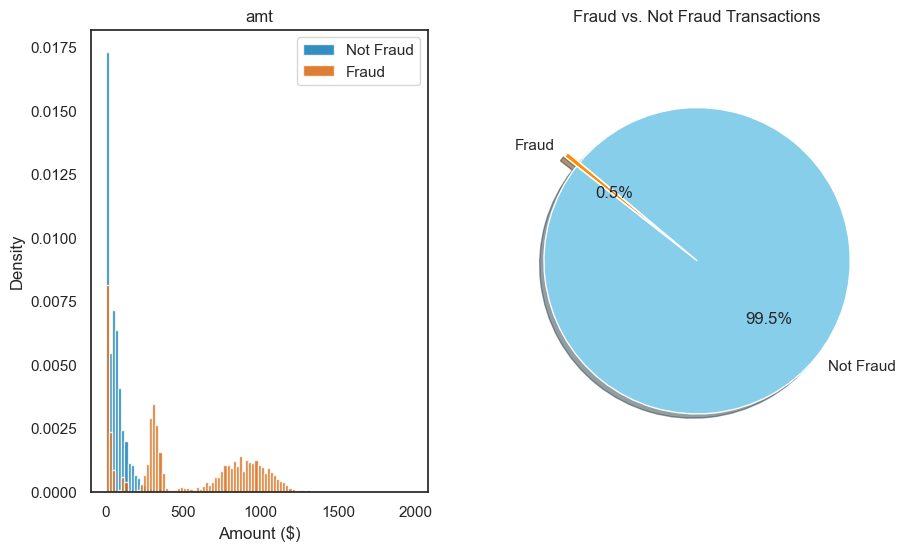

In [41]:
# The data set is massive and fraud should be relatively sparse. In order to get a better sense of what the data look like without imposing the computational load of interacting with 300K+ data points, we will sample the non-fraudulent data set such that so we have the same number of data points as the fraudulent transactions.

# Note that fraud makes up a tiny percentage of the overall data set
percent_fraud = np.round(ccf['is_fraud'].mean()*100,2)
display(f"Fraud comprises {percent_fraud: .1f}% of all transactions")
# Split the fraud and non-fraud datsets
ccf_fraud = ccf[ccf['is_fraud']==1]
ccf_true = ccf[ccf['is_fraud']==0]
ccf_true_smallsample = ccf_true.sample(len(ccf_fraud),random_state=21)
# Make the histogram
bins = np.arange(0,2000,20)
fig, (ax,ax2) = plt.subplots(1,2,figsize=(10,6))

# Use a colorblind-friendly palette
colors = ["#0072B2", "#D55E00"]  # Blue, Orange (colorblind-friendly)

nonfraudcolor = colors[0]
fraudcolor = colors[1]
# Plotting non-fraudulent transactions
ccf_true_smallsample.hist('amt',
                          bins=bins,
                          ax=ax,
                          alpha=.8,
                          color=nonfraudcolor,
                          density=True,
                          grid=False
                          )
ax.set_title('Transaction Amount Distribution')  # Set title for the histogram
ax.set_xlabel('Amount ($)')  # Set X-label for the histogram
ax.set_ylabel('Density')  # Set Y-label for the histogram
ax.legend(["Not Fraud"])
# Plotting fraudulent transactions
ccf_fraud.hist('amt',
               bins=bins,
               ax=ax,
               alpha=.8,
               color=fraudcolor,
               density=True,
               grid=False
               )

ax.legend(["Not Fraud","Fraud"])


# Pie chart of fraud
fraud_count = ccf['is_fraud'].sum()
non_fraud_count = len(ccf) - fraud_count

# Data to plot
labels = 'Fraud', 'Not Fraud'
sizes = [fraud_count, non_fraud_count]
colors = ['darkorange', 'skyblue']
explode = (0.1, 0)  # explode the first slice (fraud)

# Plot pie
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Fraud vs. Not Fraud Transactions')
plt.show()

Although higher dollar amount transactions are more likely to be fraud, there is also fraud in the range of values that are mostly populated by non-fraudulent data. Presumably, other features (such as the location of the transaction compared to the location of the merchant) may provide more explanatory power. Let's next make column of the distance between the location of the merchant and the location of the purchase. We will generate the latitude and longitude and then simply calculate the hypotenuse to determine the distance.

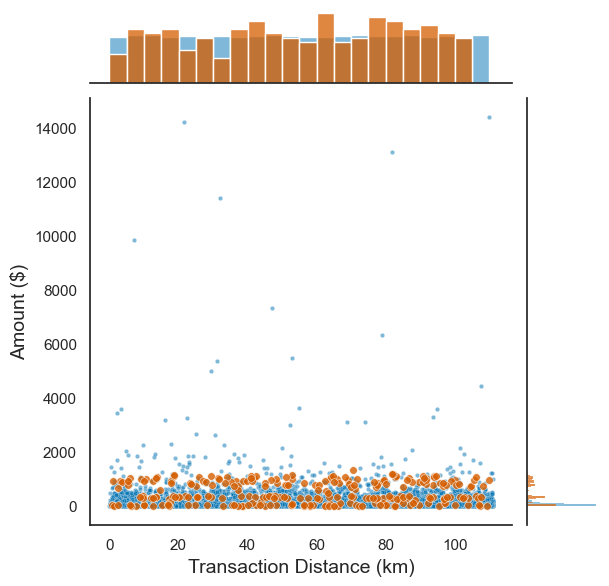

In [49]:
# 40,075 km / 360 degrees = 111 km per degree of latitude
ccf['lat_diff'] = (ccf['lat'] - ccf['merch_lat']) * 111
# Longitude – conversion to radians and determine the distance based on where you are on earth
# Note that at the equator, 1 degree = 111 km, same as latitude. However, as you move towards the poles this gets shorter. This latitude difference can be adjusted for in the longitude calculation 
ccf['lon_diff'] = (ccf['long'] - ccf['merch_long']) * np.deg2rad(1) * 111 * np.cos(np.deg2rad(ccf['merch_lat']))
# Calculate hypotenuse
ccf['transaction_distance'] = np.sqrt(ccf['lat_diff'] ** 2 + ccf['lon_diff'] ** 2)
# Stratified sampling to look at representative subset of data.
num_samples = 50000
fraud_samples = int(num_samples * percent_fraud/100)
nonfraud_samples = num_samples - fraud_samples
# Separate fraud and non-fraud
fraud_sample = ccf[ccf['is_fraud']==1].sample(n=fraud_samples,random_state=21)
nonfraud_sample = ccf[ccf['is_fraud']==0].sample(n=nonfraud_samples,random_state=21)
# Concatenate fraud and non-fraud samples
ccf_sample = pd.concat([fraud_sample,nonfraud_sample])

sns.set_context('notebook')
sns.set_style('white')
g = sns.JointGrid(data=ccf_sample,x='transaction_distance',y='amt',hue='is_fraud',)

# Plot non-fraudulent transactions first with smaller points and lower alpha
sns.scatterplot(data=ccf_sample[ccf_sample['is_fraud'] == 0], x='transaction_distance', y='amt',
                ax=g.ax_joint, color=nonfraudcolor, alpha=0.5, s=10)

# Overlay with fraudulent transactions with larger points and higher alpha for better visibility
sns.scatterplot(data=ccf_sample[ccf_sample['is_fraud'] == 1], x='transaction_distance', y='amt',
                ax=g.ax_joint, color=fraudcolor, alpha=0.8, s=30)

dist_binsize = 5 # in km
# Plot histograms with density on the margins for non-fraudulent transactions
sns.histplot(data=ccf_sample[ccf_sample['is_fraud'] == 0], 
             x='transaction_distance', 
             ax=g.ax_marg_x,
             stat='density', 
             color=nonfraudcolor, alpha=0.5,
             bins = np.arange(0,ccf_sample[ccf_sample['is_fraud'] == 0]['transaction_distance'].max(),dist_binsize))
sns.histplot(data=ccf_sample[ccf_sample['is_fraud'] == 0], y='amt', 
             ax=g.ax_marg_y, 
             stat='density', 
             color=nonfraudcolor, alpha=0.5, 
             bins = np.arange(0,ccf_sample[ccf_sample['is_fraud'] == 0]['amt'].max(),50))

# Overlay with histograms with density on the margins for fraudulent transactions
sns.histplot(data=ccf_sample[ccf_sample['is_fraud'] == 1], x='transaction_distance',
             ax=g.ax_marg_x,
             stat='density', 
             color=fraudcolor, alpha=0.75,
             bins = np.arange(0,ccf_sample[ccf_sample['is_fraud'] == 1]['transaction_distance'].max(),dist_binsize))
sns.histplot(data=ccf_sample[ccf_sample['is_fraud'] == 1], y='amt', 
             ax=g.ax_marg_y, 
             stat='density', 
             color=fraudcolor, alpha=0.75,
             bins = np.arange(0,ccf_sample[ccf_sample['is_fraud'] == 1]['amt'].max(),50))
g.set_axis_labels(ylabel='Amount ($)',xlabel='Transaction Distance (km)',fontsize = 14)


There seems to be no simple relationship between amount and the distance between merchant and transaction source. This is not surprising in the new global order with online shopping. Casting a wider net, next we will try some machine learning approaches which will help us determine which features of the dataset have the greatest potential for detecting fraudulent transactions.

Before moving on to more complicated models, we will first try Lasso regression. This should help us narrow down which features are most likely to have a significant impact on the prediction. This is particularly important when working with large data sets. After all, computational load will become an issue at some point.

In [48]:
# First prepare the data for regression analysis